In [19]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import joblib
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from mlxtend.plotting import plot_decision_regions

In [2]:

def getData_half(cfileName):
    """
    Reads only the first half of the complex samples from a .cfile.
    The file is assumed to contain interleaved float32 I and Q samples.
    """
    # Get file size in bytes
    file_size = os.path.getsize(cfileName)
    # Determine total number of float32 samples in the file
    num_floats = file_size // 4
    # Each complex sample requires 2 floats.
    # The full complex array would have num_floats//2 elements.
    # To get only half of that, we need to read:
    count = (num_floats // 4) * 2  # (num_floats//4 complex samples)
    
    # Read only 'count' float32 numbers from the file
    data = np.fromfile(cfileName, dtype="float32", count=count)
    
    # Form complex samples: every pair (I, Q)
    data_complex = data[0::2] + 1j * data[1::2]
    
    return data_complex



In [3]:
# number of samples per class
num_samp_per_class = 10000

# FFT size for the STFT operation (which is same as the feature vector size)
fft_size = feature_vector_size = 2048

# number of overlapping samples for the STFT operation
fft_overlap = 256

In [4]:
class_label = 0

In [5]:
data = getData_half("/media/rasi/Other/data/API-Security/hypothesis1/autheticated_firemware/original")
print(data.shape)

(212153772,)


In [6]:
f, t, Zxx = signal.stft(data, fs=20e6, nperseg=fft_size, noverlap=fft_overlap)
print(len(f))
print(len(t))
print(Zxx.shape)

/tmp/ipykernel_17727/3323255673.py:1: UserWarning: Input data is complex, switching to return_onesided=False
  f, t, Zxx = signal.stft(data, fs=20e6, nperseg=fft_size, noverlap=fft_overlap)


2048
118391
(2048, 118391)


In [7]:
del data

Zxx = Zxx.transpose()

X = Zxx[:num_samp_per_class]
y = np.full(num_samp_per_class, class_label)
del Zxx

print(X.shape)
print(y.shape)

(10000, 2048)
(10000,)


In [8]:
class_label = 1 #remove random API

In [9]:
data = getData_half("/media/rasi/Other/data/API-Security/hypothesis1/unauthenticated_firemware/ping_first")
print(data.shape)

(211288125,)


In [10]:
f, t, Zxx = signal.stft(data, fs=20e6, nperseg=fft_size, noverlap=fft_overlap)
print(len(f))
print(len(t))
print(Zxx.shape)

/tmp/ipykernel_17727/3323255673.py:1: UserWarning: Input data is complex, switching to return_onesided=False
  f, t, Zxx = signal.stft(data, fs=20e6, nperseg=fft_size, noverlap=fft_overlap)


2048
117908
(2048, 117908)


In [11]:
del data

Zxx = Zxx.transpose()

X = np.concatenate((X, Zxx[:num_samp_per_class]), axis=0) 
y = np.concatenate((y, np.full(num_samp_per_class, class_label)), axis=0)
del Zxx

print(X.shape)
print(y.shape)

(20000, 2048)
(20000,)


In [12]:
X = np.abs(X)
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [13]:
# Split data to train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [ ]:

plt.figure(figsize=(8,6))
plot_decision_regions(X_train, y_train, clf=clf, legend=2)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("SVM Decision Boundary")
plt.show()

In [20]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
lda_score = lda.score(X_test, y_test)

print(f"LDA Score: {lda_score:.4f}")

LDA Score: 0.8220


In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(X[y==0, 0], X[y==0, 1], color='red', label='Class 0')
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', label='Class 1')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.title("Scatter Plot of Data")
plt.show()

In [21]:
clf_linear = SVC(kernel="linear").fit(X_train, y_train)
clf_rbf = SVC(kernel="rbf").fit(X_train, y_train)

print(f"Linear SVM Accuracy: {accuracy_score(y_test, clf_linear.predict(X_test)):.4f}")
print(f"RBF SVM Accuracy: {accuracy_score(y_test, clf_rbf.predict(X_test)):.4f}")

Linear SVM Accuracy: 0.8380
RBF SVM Accuracy: 0.8850


In [14]:
clf = SVC()
clf.fit(X_train, y_train)
# Save the model
joblib.dump(clf, "/media/rasi/Other/data/model/svm_ping_first.pkl")  # Saves as a .pkl file
print("Model saved successfully!")
del clf

Model saved successfully!


In [15]:
clf = joblib.load("/media/rasi/Other/data/model/svm_ping_first.pkl")

y_pred = clf.predict (X_test)
# Evaluate accuracy
print("SVM Accuracy:", accuracy_score(y_test, y_pred))

SVM Accuracy: 0.885


In [16]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[858 127]
 [103 912]]
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       985
           1       0.88      0.90      0.89      1015

    accuracy                           0.89      2000
   macro avg       0.89      0.88      0.88      2000
weighted avg       0.89      0.89      0.88      2000



In [17]:
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(clf, X, y, cv=skf, scoring="accuracy")

# Print results
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Cross-validation scores: [0.87725 0.8765  0.87925 0.88475 0.8835 ]
Mean Accuracy: 0.8802 ± 0.0033


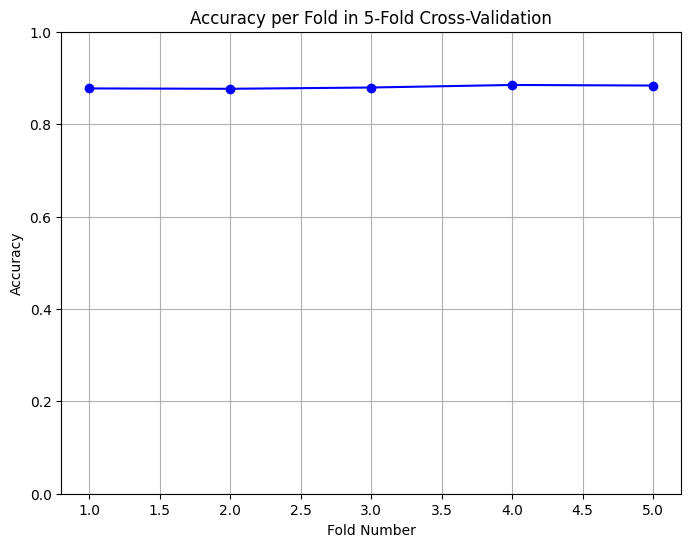

In [18]:
plt.figure(figsize=(8,6))
plt.plot(range(1, n_folds+1), cv_scores, marker='o', linestyle='-', color='blue')
plt.title(f"Accuracy per Fold in {n_folds}-Fold Cross-Validation")
plt.xlabel("Fold Number")
plt.ylabel("Accuracy")
plt.ylim(0, 1)  # Accuracy range (0 to 1)
plt.grid(True)
plt.show()